(3site-cycle-fin-nb)=
# 1D cycle of 1D finite tight-binding model

This example considers a simple three-site one-dimensional tight-binding
model parametrized by some parameter $\lambda$. As $\lambda$
is changed from 0 to 1, the deepest onsite term is moved from the first
to second, then to the third, and then back to the first tight-binding
orbital. Therefore, we expect that Wannier center of the lowest band will
shift by one lattice vector as $\lambda$ changes from 0 to 1.

Also plots the individual on-site energies, band structure, and Wannier
center of lowest band.

In [1]:
from pythtb import TBModel, WFArray, Mesh
import numpy as np
import matplotlib.pyplot as plt

Define function to construct model

In [2]:
def set_model(t, delta, lmbd):
    lat = [[1]]
    orb = [[0], [1/3], [2/3]]
    model = TBModel(1, 1, lat, orb)
    model.set_hop(t, 0, 1, [0])
    model.set_hop(t, 1, 2, [0])
    model.set_hop(t, 2, 0, [1])
    onsite_0 = delta * -np.cos(2*np.pi * (lmbd - 0/3))
    onsite_1 = delta * -np.cos(2*np.pi * (lmbd - 1/3))
    onsite_2 = delta * -np.cos(2*np.pi * (lmbd - 2/3))
    model.set_onsite([onsite_0, onsite_1, onsite_2])
    return model

In [3]:
# set model parameters
delta = 2.0
t = -1.3

In [4]:
# get model at arbitrary lambda for initializations
my_model = set_model(t, delta, 0)

# set up 1d Brillouin zone mesh
num_kpt = 31
(k_vec, k_dist, k_node) = my_model.k_path([[-0.5], [0.5]], num_kpt, report=False)

path_steps = 21
all_lambda = np.linspace(0, 1, path_steps, endpoint=True)

In [5]:
mesh = Mesh(my_model)
mesh.build_grid(shape_k=(31,), shape_param=(21,), full_grid=True, gamma_centered=True)

In [6]:
wf_kpt_lambda = WFArray(my_model, mesh)

In [7]:
# evolve tight-binding parameter lambda along a path
for i, lmbd in enumerate(all_lambda):
    my_model = set_model(t, delta, lmbd)
    evals, evecs = my_model.solve_ham(k_vec, return_eigvecs=True)
    for j in range(num_kpt):
        wf_kpt_lambda[j, i] = evecs[j]

:::{versionadded} 2.0.0
:::

To compute the Chern numbers, we will use the `WFArray.chern_num` method, which calculates the integrated Berry flux for a given set of bands and a specified plane in the Brillouin zone.

In [8]:
# compute integrated curvature
chern_0 = wf_kpt_lambda.chern_num(state_idx=[0], plane=(0,1))
chern_1 = wf_kpt_lambda.chern_num(state_idx=[1], plane=(0,1))
chern_2 = wf_kpt_lambda.chern_num(state_idx=[2], plane=(0,1))
chern_01 = wf_kpt_lambda.chern_num(state_idx=[0,1], plane=(0,1))
chern_012 = wf_kpt_lambda.chern_num(state_idx=[0,1,2], plane=(0,1))

print("Chern numbers for rising fillings")
print(f"  Band  0     = {chern_0:5.2f}")
print(f"  Bands 0,1   = {chern_01:5.2f}")
print(f"  Bands 0,1,2 = {chern_012:5.2f}")
print("")
print("Chern numbers for individual bands")
print(f"  Band  0 = {chern_0:5.2f}")
print(f"  Band  1 = {chern_1:5.2f}")
print(f"  Band  2 = {chern_2:5.2f}")
print("")

Chern numbers for rising fillings
  Band  0     = -1.00
  Bands 0,1   =  1.00
  Bands 0,1,2 =  0.00

Chern numbers for individual bands
  Band  0 = -1.00
  Band  1 =  2.00
  Band  2 = -1.00



In [9]:
# now loop over parameter again, this time for finite chains
path_steps = 241
all_lambda = np.linspace(0, 1, path_steps, endpoint=True)

# length of chain, in unit cells
num_cells = 10
num_orb = 3 * num_cells

# initialize array for chain eigenvalues and x expectations
ch_eval = np.zeros([num_orb, path_steps], dtype=float)
ch_xexp = np.zeros([num_orb, path_steps], dtype=float)

for i_lambda in range(path_steps):
    lmbd = all_lambda[i_lambda]

    # construct and solve model
    my_model = set_model(t, delta, lmbd)
    ch_model = my_model.cut_piece(num_cells, 0)
    (eval, evec) = ch_model.solve_ham(return_eigvecs=True)

    # save eigenvalues
    ch_eval[:, i_lambda] = eval
    ch_xexp[:, i_lambda] = ch_model.position_expectation(evec, 0)

Plot eigenvalues vs. $\lambda$

:::{note}
Symbol size is reduced for states localized near left end
:::

(0.0, 1.0)

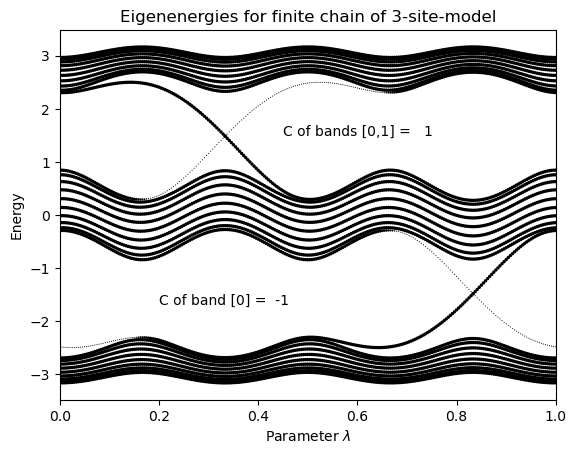

In [10]:
fig, ax = plt.subplots()

# loop over "bands"
for n in range(num_orb):
    # diminish the size of the ones on the borderline
    xcut = 2  # discard points below this
    xfull = 4 # use sybols of full size above this
    size = (ch_xexp[n, :] - xcut) / (xfull - xcut)
    for i in range(path_steps):
        size[i] = min(size[i], 1.0)
        size[i] = max(size[i], 0.1)
    ax.scatter(all_lambda[:], ch_eval[n, :], edgecolors="none", s=size * 6.0, c="k")

# annotate gaps with bulk Chern numbers calculated earlier
ax.text(0.20, -1.7, f"C of band [0] = {chern_0:3.0f}")
ax.text(0.45, 1.5, f"C of bands [0,1] = {chern_01:3.0f}")

ax.set_title("Eigenenergies for finite chain of 3-site-model")
ax.set_xlabel(r"Parameter $\lambda$")
ax.set_ylabel("Energy")
ax.set_xlim(0.0, 1.0)